## Importando módulos necessários e lendo o arquivo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
%matplotlib inline
sns.set(font_scale = 1.2)
import warnings
warnings.simplefilter("ignore")

df = pd.read_csv('db_p3.txt', sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 4 columns):
n     25 non-null int64
X1    25 non-null int64
X2    25 non-null int64
Y     25 non-null float64
dtypes: float64(1), int64(3)
memory usage: 880.0 bytes


Dataset contém quatro colunas (1 índice, 2 features e 1 target) com 0 valores missing! X1 e X2 são variáveis preditoras de Y.

## Análise Exploratória

In [2]:
# Resumo do dataset

df.describe()

,n,X1,X2,Y
count,25.000000,25.000000,25.000000,25.000000
mean,13.000000,8.240000,331.760000,29.032800
std,7.359801,5.395059,180.304206,15.950372
min,1.000000,1.000000,50.000000,9.600000
25%,7.000000,4.000000,200.000000,17.080000
50%,13.000000,8.000000,360.000000,24.450000
75%,19.000000,11.000000,500.000000,37.000000
max,25.000000,20.000000,600.000000,69.000000


É notório a diferença de escala entre as variáveis X1 e X2. Provavelmente, são medidas com unidades diferentes. Isso pode ocasionar a ocorrência de um viés indesejável no modelo. Por isso, em algum momento, seria interessante o escalonamento ou normalização das variáveis com o objetivo de uniformizar a escala.

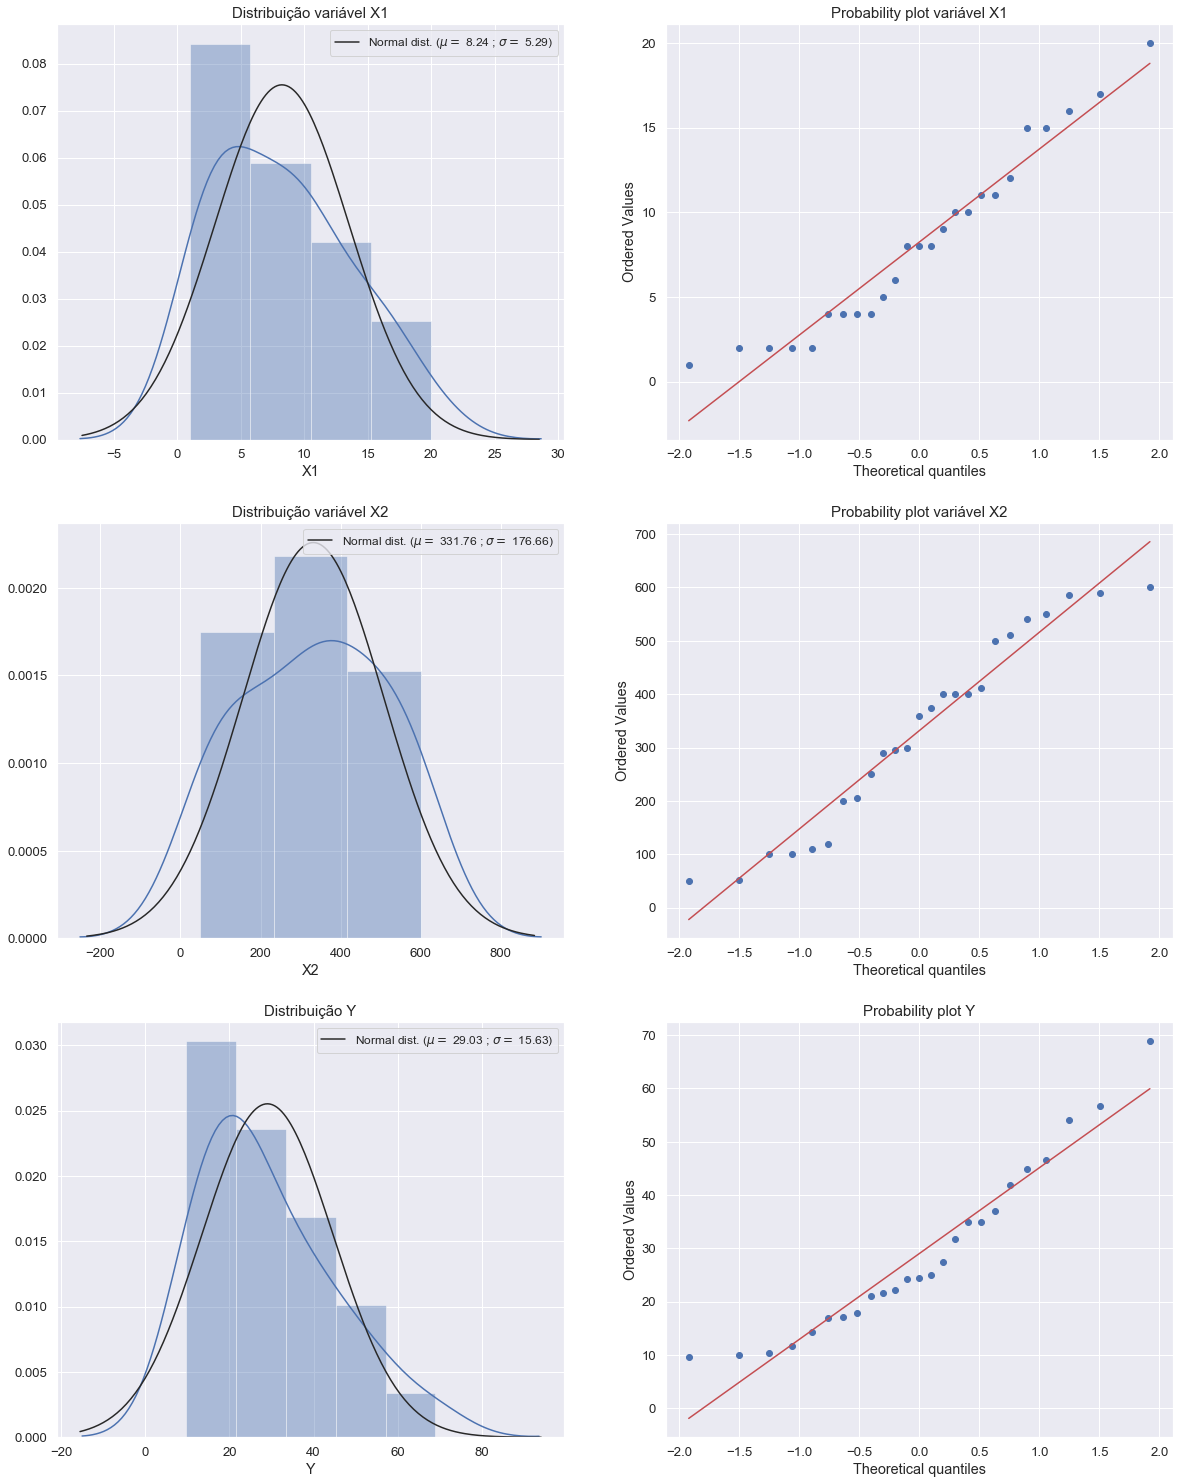

In [3]:
# Histograma e normal probability plot das variáveis independentes

fig, axes = plt.subplots(3,2, figsize=(20,26))

sns.distplot(df['X1'], fit=norm, ax = axes[0,0])
mu, sigma = norm.fit(df['X1'])
axes[0,0].set_title('Distribuição variável X1', fontsize = 15)
axes[0,0].legend(['Normal dist. ($\mu = $ {:.2f} ; $\sigma = $ {:.2f})'.format(mu, sigma)], loc='best', fontsize = 12)

sns.distplot(df['X2'], fit=norm, ax = axes[1,0])
mu_2, sigma_2 = norm.fit(df['X2'])
axes[1,0].set_title('Distribuição variável X2', fontsize = 15)
axes[1,0].legend(['Normal dist. ($\mu = $ {:.2f} ; $\sigma = $ {:.2f})'.format(mu_2, sigma_2)], 
                 loc='upper right', fontsize = 12)

sns.distplot(df['Y'], fit=norm, ax = axes[2,0])
mu_3, sigma_3 = norm.fit(df['Y'])
axes[2,0].set_title('Distribuição Y', fontsize = 15)
axes[2,0].legend(['Normal dist. ($\mu = $ {:.2f} ; $\sigma = $ {:.2f})'.format(mu_3, sigma_3)], 
                 loc='upper right', fontsize = 12)

stats.probplot(df['X1'], plot=axes[0,1])
axes[0,1].set_title('Probability plot variável X1', fontsize = 15)

stats.probplot(df['X2'], plot=axes[1,1])
axes[1,1].set_title('Probability plot variável X2', fontsize = 15)

stats.probplot(df['Y'], plot=axes[2,1])
axes[2,1].set_title('Probability plot Y', fontsize = 15)

plt.show()

Percebe-se que a variável X1 e o target Y são ligeiramente assimétricos a direita. Já a variável X2 segue aparentemente uma distribuição normal simétrica. A assimetria inerente a X1 e Y pode comprometer a premissa de variância constante nos erros do modelo, ou seja, pode levar a heteroscedasticidade. Caso isso seja realmente verificado nos desvios, pode-se corrigir o problema por meio de uma transformação logarítmica ou através da raiz quadrada (já que todos os valores são positivos).

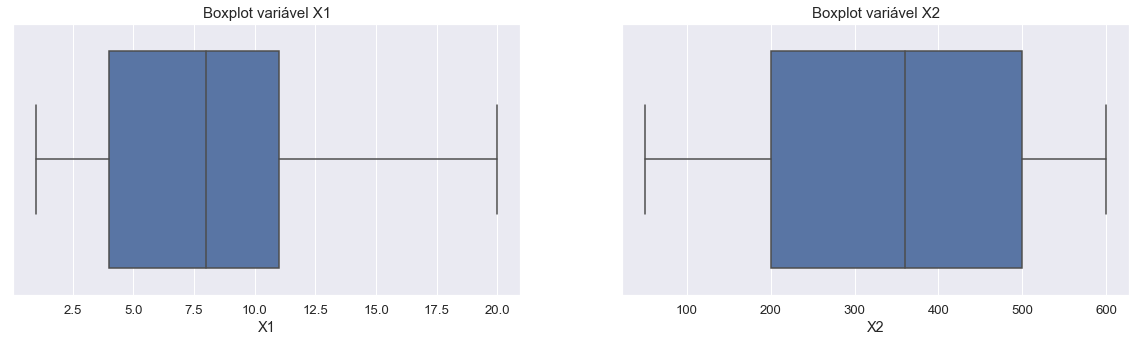

In [4]:
# Detecção de possíveis outliers

fig, axes = plt.subplots(1,2, figsize=(20,5))

sns.boxplot(df['X1'], ax = axes[0])
axes[0].set_title('Boxplot variável X1', fontsize = 15)

sns.boxplot(df['X2'], ax = axes[1])
axes[1].set_title('Boxplot variável X2', fontsize = 15)

plt.show()

Aparentemente nenhum outlier. Ok!

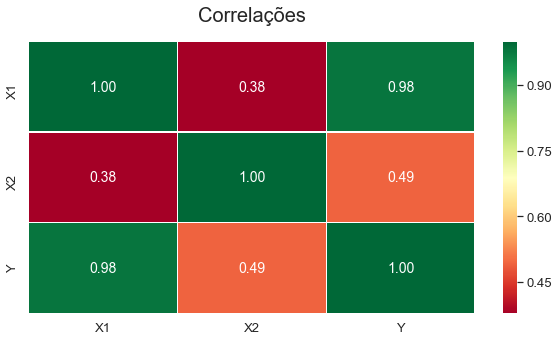

In [5]:
# Matriz de correlação entre as features e target

df_corr = df.drop('n', axis = 1)
correlations = df_corr.corr()

fig, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap(correlations, linewidths=.5, cmap = 'RdYlGn', annot = True, fmt = '.2f', annot_kws={"size": 14})
ax.set_title('Correlações', fontsize = 20, pad = 20)
plt.show()

É possível perceber uma alta correlação entre a variável X1 e Y (0.98). No entanto, a variável X2 apresenta relativamente baixa correlação com a variável Y, de apenas 0.49

Além disso, as variáveis X1 e X2 possuem pouca correlação entre si, o que indica que não serão variáveis redundantes quando adicionadas ao modelo.

A métrica de correlação utilizada foi o r de Pearson.

### Cenário 1: Avaliando o modelo apenas com a variável X1

In [6]:
X = df['X1']
y = df['Y']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     615.1
Date:                Thu, 10 Oct 2019   Prob (F-statistic):           4.24e-18
Time:                        18:51:43   Log-Likelihood:                -62.663
No. Observations:                  25   AIC:                             129.3
Df Residuals:                      23   BIC:                             131.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1145      1.146      4.464      0.0

Beta_0:  5.1145155748969255
Beta_1:  2.902704420522219


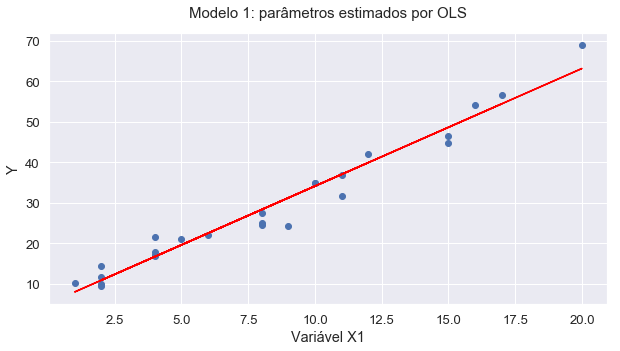

In [7]:
# Parametros calculados e um plot com a reta de regessão

beta_0 = model.params[0]
beta_1 = model.params[1]

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df['X1'], y, linestyle='none', marker='.', markersize=12)
ax.plot(df['X1'], beta_0 + beta_1*df['X1'], linestyle='-', color='red')
ax.set_title('Modelo 1: parâmetros estimados por OLS', fontsize = 15, pad = 15)
ax.set_xlabel('Variável X1')
ax.set_ylabel('Y')

print('Beta_0: ', beta_0)
print('Beta_1: ', beta_1)

plt.show()

### Cenário 2: Avaliando o modelo com as variáveis X1 e X2

In [8]:
X = df[['X1', 'X2']]
y = df['Y']

X = sm.add_constant(X)
model_2 = sm.OLS(y, X).fit()
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     572.2
Date:                Thu, 10 Oct 2019   Prob (F-statistic):           1.08e-19
Time:                        18:51:44   Log-Likelihood:                -54.568
No. Observations:                  25   AIC:                             115.1
Df Residuals:                      22   BIC:                             118.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2638      1.060      2.136      0.0

Percebe-se que, com a inserção da variável X2, houve um aumento do R2 ajustado. Isso indica que a inserção da variável adicional, apesar de inicialmente pouco correlacionada com Y, foi benéfica para aumentar o poder preditivo de Y

### Análise dos erros

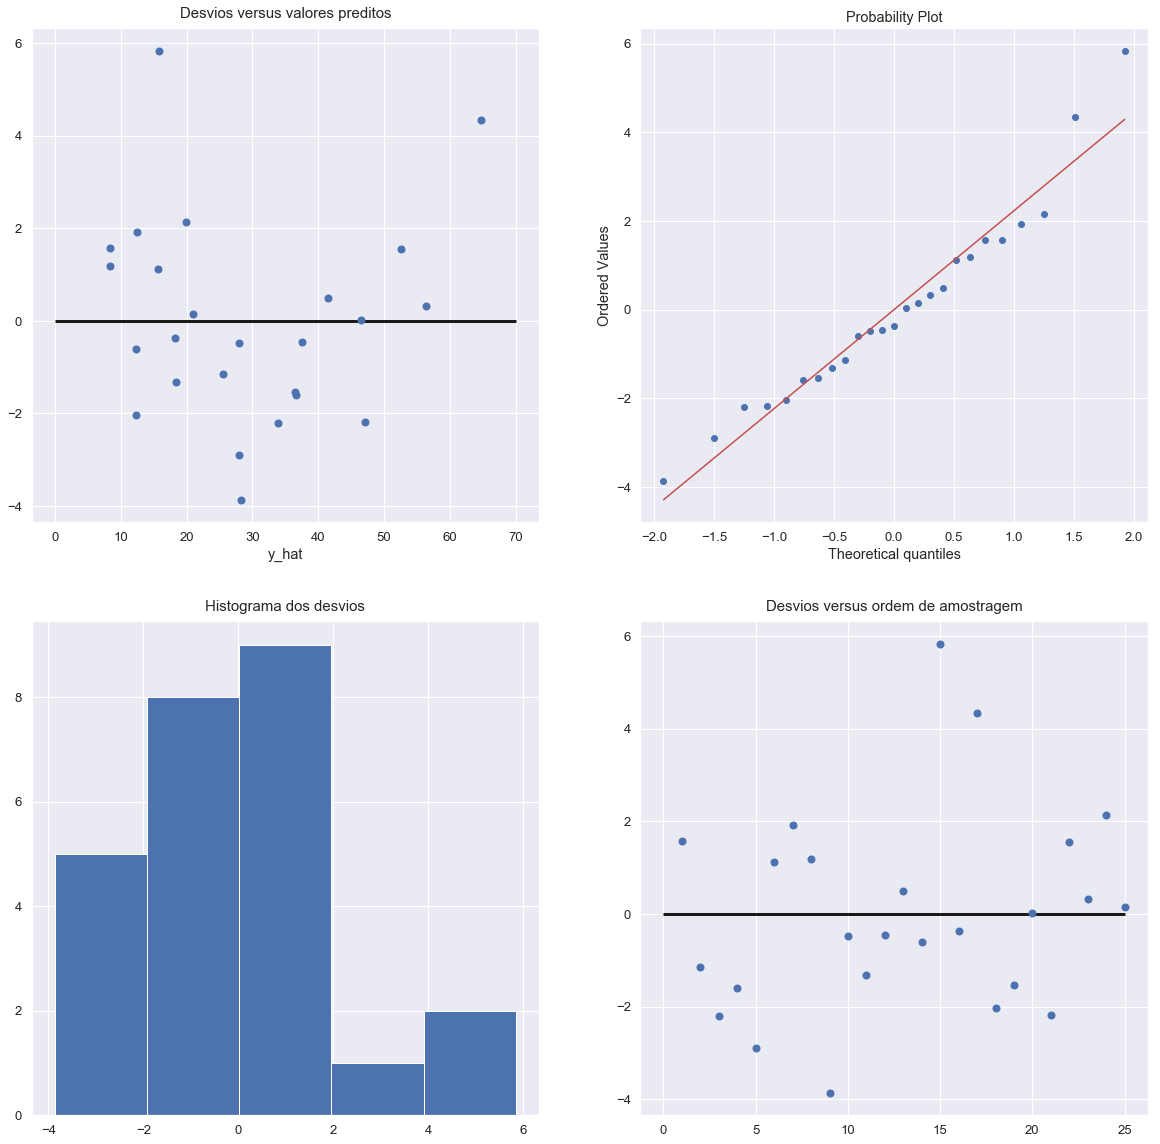

In [9]:
residuals = model_2.resid
y_hat = model_2.fittedvalues

fig, axes = plt.subplots(2, 2, figsize=(20,20))
axes[0,0].plot(y_hat, residuals, linestyle='none', marker='.', markersize=14, zorder=10)
axes[0,0].hlines(y = 0, xmin = 0, xmax = 70, linewidth=3)
axes[0,0].set_title('Desvios versus valores preditos', fontsize = 15, pad = 10)
axes[0,0].set_xlabel('y_hat')

stats.probplot(residuals, plot=axes[0,1])

axes[1,0].hist(residuals, bins = 5)
axes[1,0].set_title('Histograma dos desvios', fontsize = 15, pad = 10)

axes[1,1].plot(df['n'], residuals, linestyle='none', marker='.', markersize=14, zorder=10)
axes[1,1].hlines(y = 0, xmin = 0, xmax = 25, linewidth=3)
axes[1,1].set_title('Desvios versus ordem de amostragem', fontsize = 15, pad = 10)
plt.show()

O plot dos desvios versus os valores preditos de Y sugere um leve desvio tendendo a valores negativos em valores médios de y_hat, voltando a aproximar de 0 para valores maiores. Essa configuração ajuda a confirmar a hipótese de heteroscedasticidade, ou seja, variância dos desvios não constante. Como uma etapa adicional, pode-se realizar um teste de hipótese (como o teste de White) para comprovar o não atendimento à premissa de homoscedasticidade. Contudo, apenas a análise visual é suficiente para corroborar a necessidade de um pré-tratamento na variável X1.

O desvio em relação ao centro no 0 também pode ser verificado no histograma, em que valores negativos de erro foram mais presentes. A forma da dispersão dos desvios indica o tratamento necessário na variável X1. Neste caso, os desvios remetem a um comportamento não linear e, portanto, a transformação aplicada em X1 pode ser simplesmente o quadrado da variável.

Contudo, o plot dos desvios em relação à ordem de amostagem (nesse caso, o índice) indica que não há relação temporal e os erros não são autocorrelacionados. 

### Removendo ouliers detectados a partir da análise da dispersão dos desvios

In [10]:
df['residuals'] = residuals
df = df[df['residuals'] < 4.0]
df = df[df['residuals'] > -3.5]

## Tratamento das variáveis

Para as variáveis X1 e Y, que são ligeiramente assimétricas a direita, a correção proposta será através da transformação com a raiz quadrada do valor.

Em seguida, todas as variáveis serão normalizadas para média 0 e variância 1 (z-score) com o objeto de eliminar as diferenças de escala.

$$Z = \dfrac{x - \mu}{\sigma}$$

In [11]:
# Transformação das variáveis

df_transformed = df.apply(np.square, axis = 0)

# Normalização

def normalize_zscore(data):
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean)/std

normalized_features = pd.DataFrame({'X1_norm': df_transformed['X1'], 'X2_norm':  df_transformed['X2'], 
                                    'Y_norm':  df_transformed['Y']})
normalized_features = normalized_features.apply(normalize_zscore, axis = 0)
normalized_features.head()

,X1_norm,X2_norm,Y_norm
0,-0.932481,-1.249526,-0.963768
1,-0.252815,-1.163420,-0.412298
2,0.392867,-1.142791,0.041283
3,0.154984,1.441289,0.281128
4,-0.252815,-0.491389,-0.381122


Aparentemente a transformação conseguiu deixar as distribuições um pouco mais simétricas. Teve sucesso também em deixar as variáveis na mesma escala. Segue a validação do modelo.

## Fit após transformação de variáveis

In [12]:
X = normalized_features[['X1_norm', 'X2_norm']]
y = normalized_features['Y_norm']

X = sm.add_constant(X)
model_3 = sm.OLS(y, X).fit()
print(model_3.summary())

                            OLS Regression Results                            
Dep. Variable:                 Y_norm   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     643.9
Date:                Thu, 10 Oct 2019   Prob (F-statistic):           3.50e-18
Time:                        18:51:44   Log-Likelihood:                 15.324
No. Observations:                  22   AIC:                            -24.65
Df Residuals:                      19   BIC:                            -21.37
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.776e-17      0.028     -1e-15      1.0

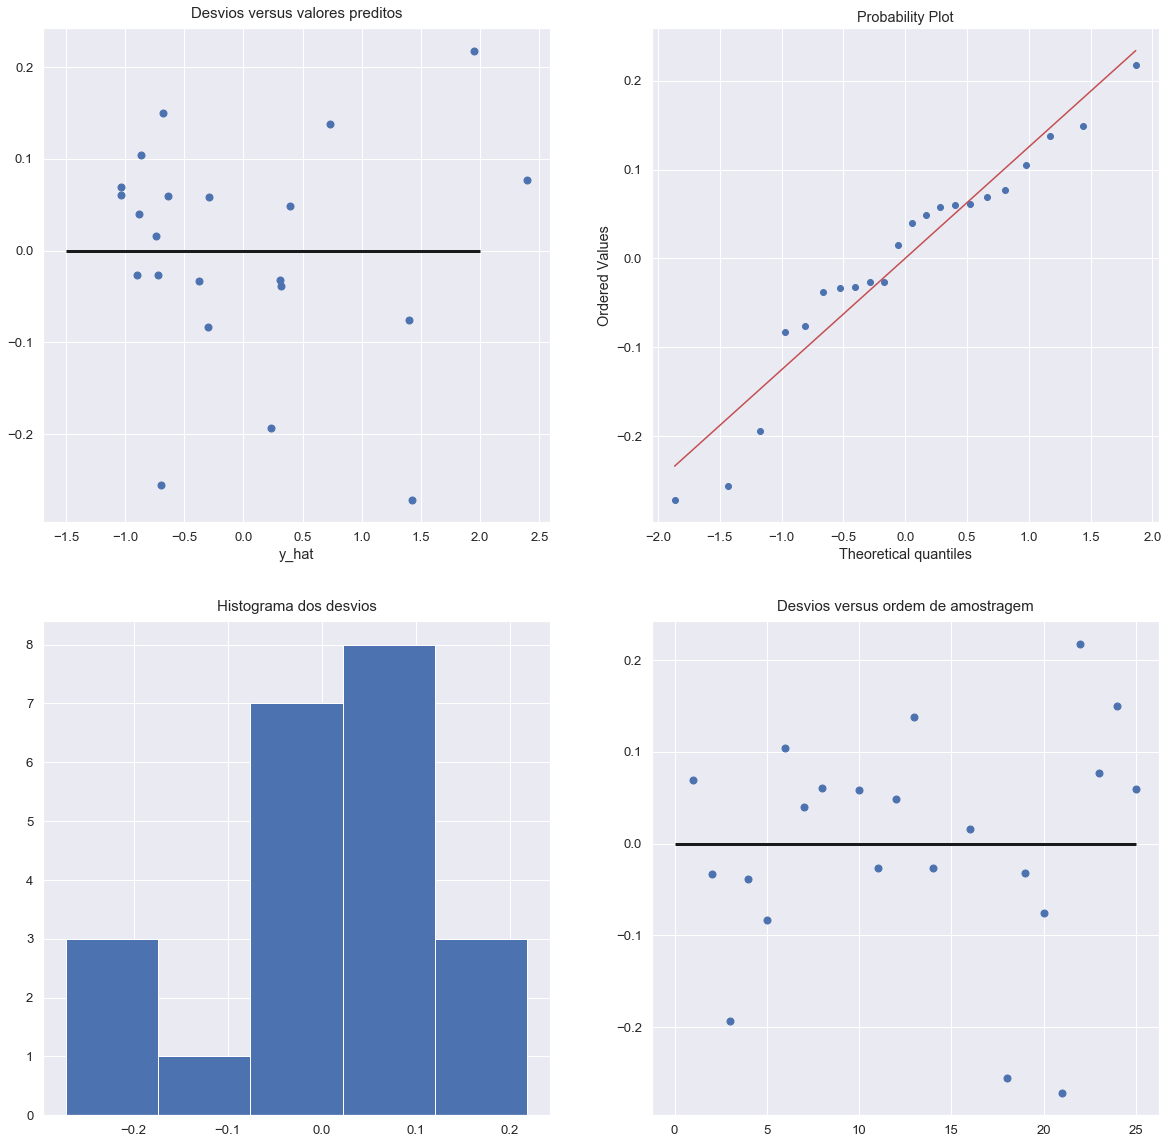

In [13]:
# Análise dos erros

residuals = model_3.resid
y_hat = model_3.fittedvalues

fig, axes = plt.subplots(2, 2, figsize=(20,20))
axes[0,0].plot(y_hat, residuals, linestyle='none', marker='.', markersize=14, zorder=10)
axes[0,0].hlines(y = 0, xmin = -1.5, xmax = 2, linewidth=3)
axes[0,0].set_title('Desvios versus valores preditos', fontsize = 15, pad = 10)
axes[0,0].set_xlabel('y_hat')

stats.probplot(residuals, plot=axes[0,1])

axes[1,0].hist(residuals, bins = 5)
axes[1,0].set_title('Histograma dos desvios', fontsize = 15, pad = 10)

axes[1,1].plot(df['n'], residuals, linestyle='none', marker='.', markersize=14, zorder=10)
axes[1,1].hlines(y = 0, xmin = 0, xmax = 25, linewidth=3)
axes[1,1].set_title('Desvios versus ordem de amostragem', fontsize = 15, pad = 10)
plt.show()

Observa-se agora os erros mais dispersos em torno da média (0), sem apresentar uma forma característica que indique não linearidade. Ainda, o histograma dos desvios também está mais simétrico. Isso indica que as transformações nas variáveis e a remoção de três outliers corroborou para a melhora da performance no modelo.

## Conclusão

O processo de feature engineering (tratamento, transformação de variáveis e remoção de outliers) contribuiu para uma melhora significativa no modelo. Com duas variáveis, o R² ajustado de 0.979 foi para 0.984 após as transformações. Além disso, percebe-se uma melhora no padrão de dispersão dos desvios.